In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import os
import sys
import numpy as np
import scipy.io as sio
from scipy.spatial import KDTree

proj_dir = os.path.join(os.pardir,os.pardir)
data_dir = os.path.join(proj_dir,'data')

src_dir = os.path.join(proj_dir,'src')
sys.path.append(src_dir)

from tools.log_progress import log_progress

coords_path = os.path.join(data_dir,'analysis','external','antbounds','shelves2.mat')
#coords_path = os.path.join(data_dir,'analysis','external','antbounds','shelves10.mat')
int_dir = os.path.join(data_dir,'analysis','interim')

fig_dir = os.path.join(os.pardir,os.pardir,'reports','figures')
grid_path = os.path.join(data_dir,'preprocessing','processed','waom4_grd.nc')

In [2]:
grd = xr.open_dataset(grid_path)
mask_vostock = (grd.lat_rho<-75) & (grd.lat_rho>-80) & (grd.lon_rho>95) & (grd.lon_rho<115)

# Creating masks
## Create ice shelf masks using ant_bounds coordinates

In [5]:
# find nearest neighbours of ant_bounds lat_lon coords on the roms grid and 
# define ice shelf masks and middle coordinates
shelves = {}

# read in ice shelf coordinates derived from ant_bounds matlab package
coords = sio.loadmat(coords_path)['shelves'][0].squeeze()

for idx in range(np.size(coords)):
    name = coords[idx][0][0]
    shelves[name]={}
    shelves[name]['lat']= coords[idx][1].squeeze()
    shelves[name]['lon']= coords[idx][2].squeeze() 

lat_flat = grd.lat_rho.stack(etaxi = ('eta_rho','xi_rho'))
lon_flat = grd.lon_rho.stack(etaxi = ('eta_rho','xi_rho'))
points = np.column_stack((lat_flat.values,lon_flat.values))
tree = KDTree(points)

for name,data in log_progress(shelves.items(),name='ice shelves'):
    
    lats = data['lat']
    lons = data['lon']

    target = np.column_stack((lats,lons))
    dist, ind = tree.query(target,k=1)
    
    eta = lat_flat[np.unique(ind)].eta_rho.values
    xi = lat_flat[np.unique(ind)].xi_rho.values
    shelves[name]['eta'] = eta
    shelves[name]['xi'] = xi
    
    mask_tmp = np.zeros_like(grd.mask_rho.values)
    mask_tmp[eta,xi] = 1
    mask_tmp[grd.zice.values == 0.0] = 0
    mask_tmp[grd.mask_rho.values == 0.0] = 0
    mask_tmp = (mask_tmp == 1)  
    shelves[name]['mask']=mask_tmp
    
    xi_m,eta_m = np.median(xi),np.median(eta)
    shelves[name]['xi_mid']=xi_m
    shelves[name]['eta_mid']=eta_m
    
dict_out_path = os.path.join(int_dir,'mask_shelves_4.npy')
np.save(dict_out_path,shelves)

/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


## create size masks

In [203]:
def make_mask_size(low_lim,up_lim):
    
    shelves_sel = {name:data for (name,data) in shelves.items() if ((data['A'] >= low_lim) & (data['A'] < up_lim))}

    mask = np.zeros_like(grd.mask_rho,dtype=bool)

    for k,v in shelves_sel.items():
        mask[v['mask']] = True
        
    return xr.DataArray(mask,dims=('eta_rho','xi_rho'))

mask_size = {}
mask_size['all'] = (grd.mask_rho == 1 ) & (grd.zice < 0.0)
mask_size['small'] = make_mask_size(0,5)
mask_size['medium'] = make_mask_size(5,45)
mask_size['large'] = make_mask_size(45,10000)
mask_size['tiny'] = mask_size['all'] & ~mask_size['small'] & ~mask_size['medium'] & ~mask_size['large'] & ~(mask_vostock)

dict_out_path = os.path.join(int_dir,'mask_size_2.npy')
np.save(dict_out_path,mask_size)

In [148]:
size=np.zeros_like(grd.mask_rho.values)

for i,mask_name in zip([1,2,3,4],['tiny','small','medium','large']):
    size[mask_size[mask_name]] = i
size = xr.DataArray(size,dims=('eta_rho','xi_rho'))   
size = size.where((grd.mask_rho ==1) & (grd.zice<0.0))

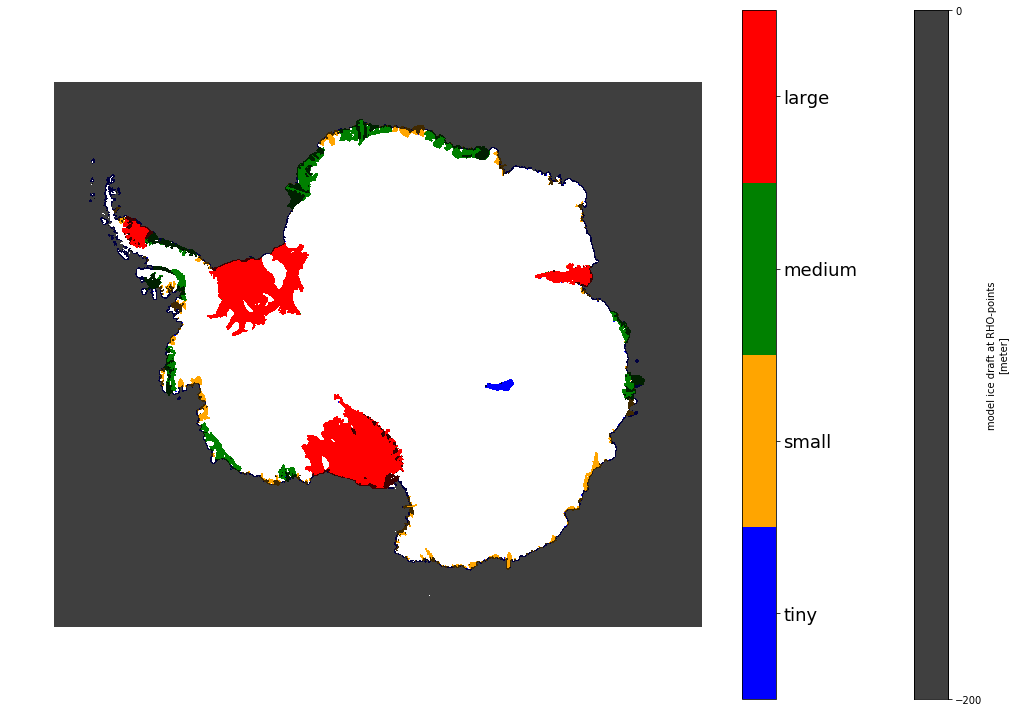

In [149]:
plt.close()
fig,ax = plt.subplots(figsize = (15,10))
colors=['blue','orange','green','red']
img = size.plot.contourf(ax=ax,levels=[0,1,2,3,4],colors=colors,add_colorbar=False)
grd.zice.where((grd.mask_rho == 1) &(grd.zice>-200)).plot.contourf(ax=ax,colors='black',levels=[-200,0],alpha=0.75)
ax.set_aspect('equal')
ax.axis('off')
cbar = plt.colorbar(img, ticks=[0.5,1.5,2.5,3.5])
cbar.ax.tick_params(labelsize=18)
cbar.ax.set_yticklabels(['tiny','small','medium','large'])
plt.tight_layout()
#plt.savefig(os.path.join(fig_dir,'size_mask.png'),transparent=True,dpi=300)
plt.show()

## create mask sector

In [4]:
mask_sector = {}
mask_sector['Total Antarctica'] = xr.DataArray(np.ones_like(grd.lon_rho,dtype=bool),dims=('eta_rho','xi_rho'))
mask_sector['Western East Antarctica'] = (grd.lon_rho>=-10.0) & (grd.lon_rho<60)
mask_sector['Amery/Prydz Bay'] = (grd.lon_rho>=60.0) & (grd.lon_rho<80.0)
mask_sector['Sabrina Coast/Aurora subglacial basin'] = (grd.lon_rho>=80.0) & (grd.lon_rho<130.0) & ~(mask_vostock)
mask_sector['George V Coast/Wilkes subglacial basin'] = ((grd.lon_rho>=130.0) & (grd.lon_rho<155.0)) | ((grd.lon_rho>=155.0) & (grd.lon_rho<170.0) & (grd.lat_rho>=-72))
mask_sector['Ross Sea'] = (grd.lon_rho>=155.0) & ~mask_sector['George V Coast/Wilkes subglacial basin'] |(grd.lon_rho<-140.0)|((grd.lon_rho>=-140.0) & (grd.lon_rho<-120.0) &(grd.lat_rho<-77.0)) 
mask_sector['Amundsen Sea'] = ((grd.lon_rho>=-140.0) & (grd.lon_rho<-120.0) & (grd.lat_rho>=-77.0)) |((grd.lon_rho>=-120.0) & (grd.lon_rho<-90.0))
mask_sector['Bellingshausen Sea'] = (grd.lon_rho>=-90.0) & (grd.lon_rho<-66.0) & (grd.lat_rho>=-75.0)
mask_sector['Weddell Sea'] = (grd.lon_rho > -90) & (grd.lon_rho < -10) & ~ mask_sector['Bellingshausen Sea']

dict_out_path = os.path.join(int_dir,'mask_sector_4.npy')
np.save(dict_out_path,mask_sector)

/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/matplotlib/contour.py:1230: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


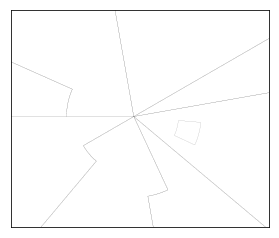

In [66]:
plt.close()
fig,ax = plt.subplots()
for k,v in mask_sector.items():
    ax.contour(v,colors=('black'),linewidths=0.01)
ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect('equal')
plt.savefig(os.path.join(fig_dir,'tmp','lines.png'),transparent=True,dpi=300)
plt.show()

## create mask on the continental shelf

<IPython.core.display.Javascript object>


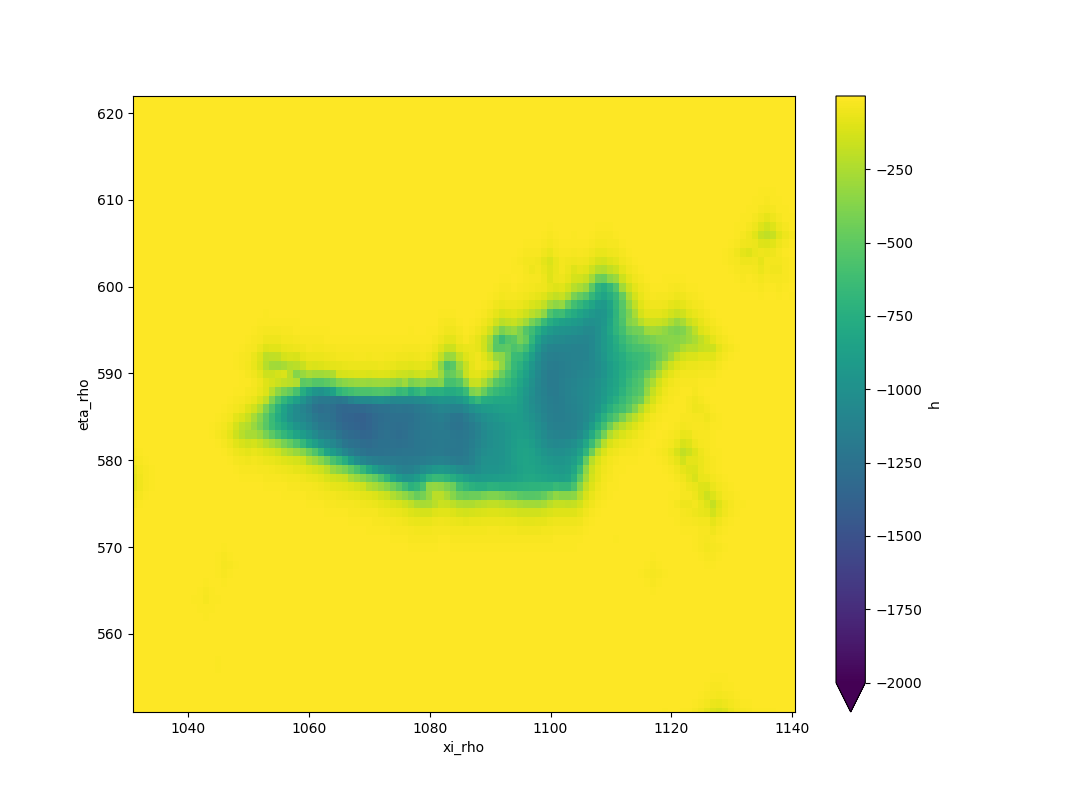

In [22]:
(-1*grd.h).plot(size=8,vmin=-2000)

In [17]:
mask_shelf = ((grd.h < 1000) & (grd.mask_rho ==1) & (grd.zice == 0.0)) | ((grd.zice < 0.0) & (grd.mask_rho ==1))
mask_shelf_sector = {}
for key,item in mask_sector.items():
    mask_shelf_sector[key] = (item & mask_shelf)
mask_shelf_sector['Amundsen Sea'] &= grd.lat_rho < -70 
mask_shelf_sector['Ross Sea'] &= grd.lat_rho < -70
mask_shelf_sector['George V Coast/Wilkes subglacial basin'] &= ~((grd.lon_rho > 160) & (grd.lat_rho > -68.5)) 
mask_shelf_sector['Sabrina Coast/Aurora subglacial basin'] &= grd.lat_rho <= -64
mask_shelf_sector['Western East Antarctica'] &= grd.lat_rho < -64
mask_shelf_sector['Weddell Sea'] &= ~((grd.lat_rho > -63) & (grd.lon_rho > -48))

mask_shelf_sector['Total Antarctica'] = mask_shelf_sector['Amundsen Sea'].copy()
for key,item in mask_shelf_sector.items():
    mask_shelf_sector['Total Antarctica'] |= item
    
dict_out_path = os.path.join(int_dir,'mask_shelf_2.npy')
np.save(dict_out_path,xr.DataArray(mask_shelf_sector['Total Antarctica'],dims=('eta_rho','xi_rho')))

<IPython.core.display.Javascript object>


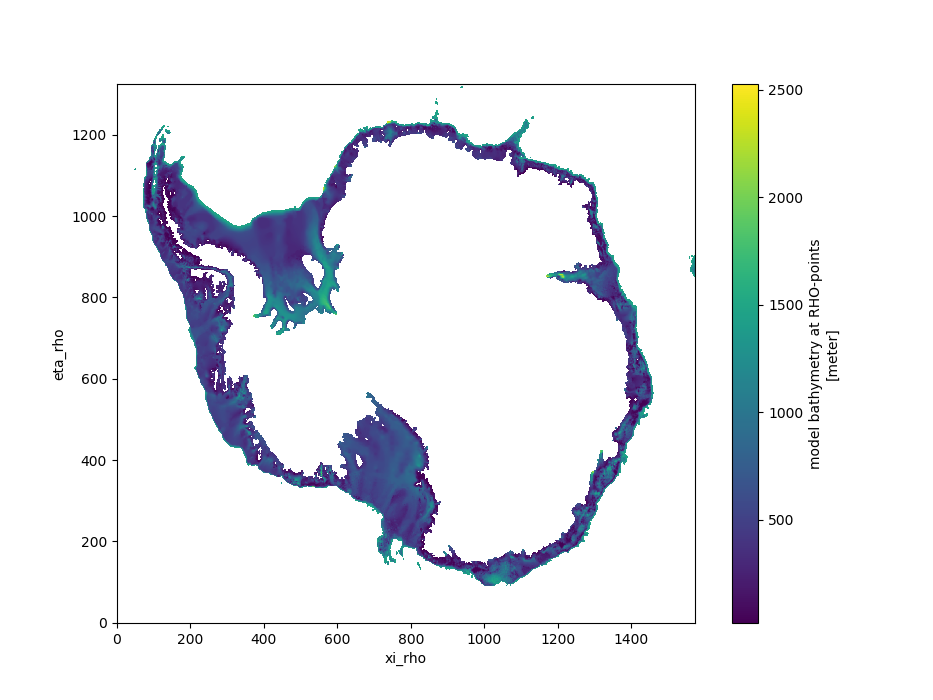

In [16]:
%matplotlib notebook
plt.close()
grd.h.where(mask_shelf_sector['Total Antarctica']).plot(size=7)
plt.show()

## create mask front

In [67]:
def make_mask_front(grd,nb_cells):
    
    mask_rho = grd.mask_rho.values
    mask_land = np.zeros_like(mask_rho)
    mask_land[mask_rho == 0] = 1
    mask_zice = np.zeros_like(mask_land)
    mask_zice[grd.zice.values*mask_rho != 0] = 1

    mask_front = np.zeros_like(grd.mask_rho.values)

    for j in grd.eta_rho.values:
        for i in grd. xi_rho.values:
            if mask_zice[j,i] == 1:
                j_min = max(j-nb_cells,0)
                j_max = min(j+nb_cells, np.size(mask_rho,0))
                i_min = max(i-nb_cells,0)
                i_max = min(i+nb_cells+1, np.size(mask_rho,1))

                if np.any(mask_zice[j_min:j_max,i_min:i_max] + mask_land[j_min:j_max,i_min:i_max]== 0):
                        mask_front[j,i] = 1
                        
    #grd['mask_front'] = (('eta_rho','xi_rho'),mask_front)
    
    return mask_front

mask_front = make_mask_front(grd,3)

dict_out_path = os.path.join(int_dir,'mask_front_2.npy')
np.save(dict_out_path,mask_front)

<IPython.core.display.Javascript object>


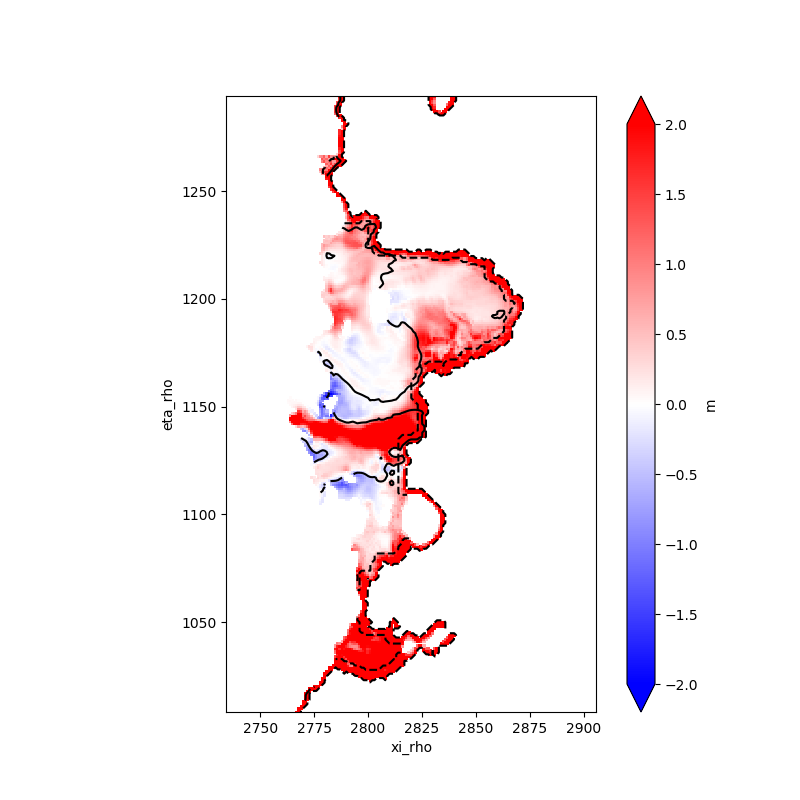

In [56]:
%matplotlib notebook
levels = [-200]
mask_shelf = (grd.mask_rho == 1) & (grd.zice < 0.0)
plt.close()
fig,ax = plt.subplots(figsize=(8,8))
(avg.where(mask_shelf).m*s2a).plot(ax=ax,vmin=-2,vmax=2,cmap='bwr')
cs = grd.zice.where(grd.mask_rho).plot.contour(levels=levels,ax=ax,colors='k')
grd.mask_front.where(grd.mask_rho).plot.contour(levels=[0.1],ax=ax,colors='k',linestyles='dashed')
ax.set_aspect('equal')
plt.show()

## depth mask

In [11]:
%matplotlib inline

depth1 = -200
depth2 = -400


depth_mask = grd.mask_rho.copy()
depth_mask.values[grd.zice == 0.0] = 0

depth_mask.values[(grd.zice >= depth1) & (grd.zice < 0.0)] = 1
depth_mask.values[(grd.zice >= depth2) & (grd.zice < depth1)] = 2
depth_mask.values[grd.zice < depth2] = 3

mask_depth = {}
mask_depth['all'] = (grd.mask_rho == 1) & (grd.zice < 0.0)
mask_depth['shallow'] = (grd.mask_rho == 1) & (depth_mask == 1)
mask_depth['mid'] = (grd.mask_rho == 1) & (depth_mask == 2)
mask_depth['deep'] = (grd.mask_rho == 1) & (depth_mask == 3)

dict_out_path = os.path.join(int_dir,'mask_depth_2.npy')
np.save(dict_out_path,mask_depth)

In [69]:
plt.close()
fig,ax = plt.subplots(figsize=(12,8))
img = depth_mask.where(grd.mask_rho).plot(ax=ax,add_colorbar=False)
plt.colorbar(img, ax=ax)
ax.set_aspect('equal')
plt.show()